In [1]:
import numpy
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.optimize
%matplotlib inline
from numpy import asarray

In [2]:
def uniquify(seq, idfun=None): 
   # order preserving
    if idfun is None:
        def idfun(x): return x
    seen = {}
    result = []
    for item in seq:
        marker = idfun(item)
        # in old Python versions:
        # if seen.has_key(marker)
        # but in new ones:
        if marker in seen: continue
        seen[marker] = 1
        result.append(item)
    return result

# Data

In [3]:
# t1 is for Cx and t2 is for rCO2 (both are in hours)
t1 = [1.5, 2.5, 3.5, 4.5, 5.5] 
t2 = [1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25] 

In [4]:
# A4
Cx_4_A = [0.8481632, 0.9537056, 1.300734, 1.606674, 2.0594652] # g/L
rco2_4_A = [2.60, 3.00, 3.70, 4.00, 4.70, 5.20, 6.10, 7.10, 8.10] # ml/min

In [5]:
# B4
Cx_4_B = [1.0804572, 1.2477044, 1.596476, 1.9085348, 2.3735636] # g/L
rco2_4_B = [3.2, 3.68, 4.228, 5.666, 8.093, 7.8, 7.88, 7.6, 7.3
] # ml/min

In [6]:
# C4
Cx_4_C = [1.8126736, 2.0227524, 2.024792, 2.3735636, 2.6795] # g/L
rco2_4_C = [12, 11, 10.5, 6.65, 7.2, 7.619, 8.2759, 9.166, 9.68] # ml/min

In [7]:
Cx_4_avg=[]
for index,value in enumerate(Cx_4_A):
    sum_avg=Cx_4_A[index]+Cx_4_B[index]+Cx_4_C[index]
    Cx_4_avg.append(sum_avg/3)

Cx_4_avg

[1.247098,
 1.4080541333333334,
 1.6406673333333337,
 1.9629241333333336,
 2.3708429333333334]

In [8]:
rco2_4_avg=[]
for index,value in enumerate(rco2_4_A):
    sum_avg=rco2_4_A[index]+rco2_4_C[index]+rco2_4_B[index]
    rco2_4_avg.append(sum_avg/3)
rco2_4_avg

[5.933333333333334,
 5.8933333333333335,
 6.142666666666666,
 5.438666666666667,
 6.664333333333334,
 6.873,
 7.418633333333333,
 7.955333333333333,
 8.360000000000001]

In [9]:
alpha, beta, theta = 0.1, 0.1, 0.05
mu, gamma = 0.235, 1.45
Km = 0.00001

# Mu Fit Exp 4

In [10]:
t1_array = numpy.array([1.5, 2.5, 3.5, 4.5, 5.5])
t2_array = numpy.array([0,1.5, 2.5, 3.5, 4.5, 5.5])

In [11]:
def bio(t,mu1,CA0):

    return CA0*scipy.e**(mu1*(t))

In [12]:
params = scipy.optimize.curve_fit(bio,t1_array,Cx_4_avg,p0 =(0.5,0.5))[0]
mu_fit,Ca0_fit = params

print (mu_fit,Ca0_fit)

Cx_fit= bio(t2_array,mu_fit,Ca0_fit)



0.1668644279014969 0.935802737406813


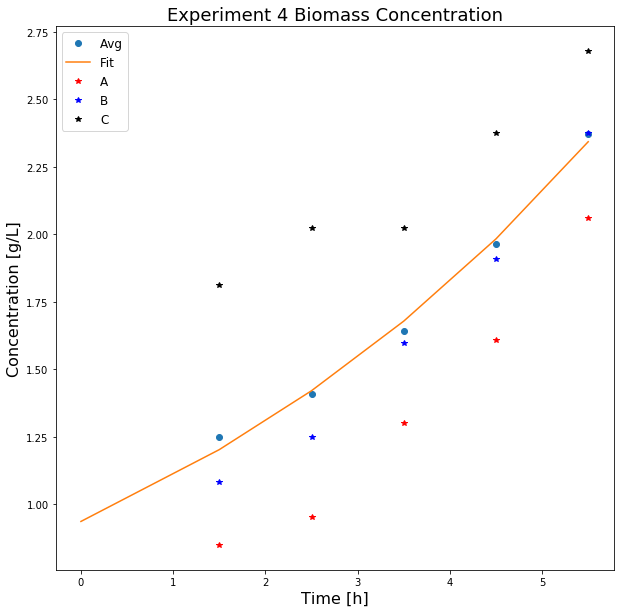

In [13]:
plt.figure(figsize=(10,10))

plt.title('Experiment 4 Biomass Concentration', fontsize = 18)

plt.xlabel('Time [h]', fontsize = 16)
plt.ylabel('Concentration [g/L]', fontsize = 16)

plt.plot(t1,Cx_4_avg,"o", label = "Avg")
plt.plot(t2_array,Cx_fit, label = "Fit")

plt.plot(t1, Cx_4_A,'*', color='red', label='A')
plt.plot(t1, Cx_4_B,'*', color='blue', label='B')
plt.plot(t1, Cx_4_C, '*', color='black', label='C')

plt.legend(loc='best', fontsize = 12)
plt.savefig('Mu_fit_E1.jpeg',dpi=1000)


In [14]:
Cx_fit[0]

0.935802737406813

In [15]:
mu = mu_fit
mu

0.1668644279014969

# Fitting Gamma

In [16]:
t3_array = numpy.array([1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25])

In [17]:
T = 22 + 273.15
P = 101.325 #kPa

In [18]:
t_0 = 1.5
t_add1 = 3.0
t_add2 = 4.0
tmax=6

t_important = [0,t_0,t_add1, t_add2, tmax]
t_important

[0, 1.5, 3.0, 4.0, 6]

In [19]:
def response_fun(C):
    
    Cx, Ce, Cs = C[0],C[1], C[2]
    
    mu1=mu*Cs/(Km+Cs)
    theta1=theta
             
    S = numpy.matrix([[-1,1+alpha,1,0,0],
                      [ 0,0,-1,1,1.5],
                      [  0,beta,0,-1/3,0],
                      [ 0,-gamma,-1/3,0,1],
                      [ 0,1,0,0,0]])

    C = numpy.matrix([0, 0, 0, theta1, mu1]).T
    r = numpy.linalg.solve(S, C) 
        
    
    return [mu,        # biomass
            r[4,0],    # ethanol   
            r[0, 0]]    

In [20]:
def ferm_eq(t,C):
    Cx, Ce, Cs = C[0],C[1], C[2]   
    r=response_fun([Cx, Ce, Cs])
    
    return [r[0]*Cx,
            r[1]*Cx,
            r[2]*Cx]   

In [21]:
error = 1000
gamma_span = numpy.arange(0,2,0.001)

for gamma in gamma_span:
    
    squares = 0
    
    #Initial Concentrations at T=1.5
    Cx0 = Cx_fit[0]/24.6  #Initial Biomass Concentration g/L
    Ce0=0 #Non zero but low Ethanol Concentration
    Cg0=(25*2)/30 #Glucose as initially added
    Co=[Cx0, Ce0, Cg0]
    
    tspan = [0,6]

    C_sol=numpy.array([[],[],[]])
    t_sol=numpy.array([])
    
    for index,time in enumerate(t_important):

        if index==0:
            pass

        else:
            t_span=[t_important[index-1],time]
            teval=numpy.arange(t_important[index-1],time+0.5,0.5)
#             print (teval)

            C = scipy.integrate.solve_ivp(ferm_eq, t_span, Co, t_eval=teval)
#             print (C.y)

            C_sol=numpy.concatenate((C_sol,C.y),axis=1)

            Cx0 = C.y[0,-1]
            Ce0 = C.y[1,-1]
            Cg0 = C.y[2,-1]+((5*2)/30)
            Co=[Cx0, Ce0, Cg0]

            t_sol=numpy.concatenate((t_sol,teval))
            
            
            
    C_x_unique = numpy.array(uniquify(C_sol[0]))
    
#     Cx_u_2 = bio(t3_array,mu,Cx_fit[0])
    
    rco2_fit = []
    
    print (C_x_unique*24.6, gamma, Cx0)
    
    for index,value in enumerate(rco2_4_avg):
        
        rates = response_fun((C_sol[0][index], C_sol[1][index], C_sol[2][index]))

        rx, re, rs = rates

    
        fitted_rco2 = (0.5*re+alpha*rx)*(1/60)*8.314*(T+273)*1000/P*(C_x_unique[index]*24.6)/24.6*0.5

        squares+=(fitted_rco2-value)**2

        rco2_fit.append(fitted_rco2)
            
    if squares<error:
            
        gamma_acc=gamma
        error=squares
        rco2_fit_acc=rco2_fit

gamma_acc, mu

[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285848 2.15538991 2.3429336
 2.54679583] 0.0 0.10352828595646975
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285848 2.15538991 2.3429336
 2.54679583] 0.001 0.10352828595564906
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285848 2.15538991 2.3429336
 2.54679583] 0.002 0.10352828595483309
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285848 2.15538991 2.3429336
 2.54679583] 0.003 0.10352828595402191
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285848 2.15538991 2.3429336
 2.54679583] 0.004 0.10352828595321562
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285848 2.15538991 2.3429336
 2.546795

 2.54679583] 0.047 0.10352828592256716
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.048 0.10352828592193836
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.049 0.10352828592131305
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.05 0.10352828592069116
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.051000000000000004 0.10352828592007257
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.052000000000000005 0.10352828591945738
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54

 2.54679583] 0.1 0.10352828589346853
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.101 0.10352828589299322
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.10200000000000001 0.10352828589252044
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.10300000000000001 0.10352828589205003
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.10400000000000001 0.10352828589158199
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.105 0.10352828589111629
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.420

 2.54679583] 0.156 0.10352828587021125
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.157 0.10352828586985167
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.158 0.10352828586949367
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.159 0.10352828586913743
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.16 0.10352828586878304
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.161 0.10352828586843026
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1

 2.54679583] 0.218 0.10352828585087263
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.219 0.10352828585060482
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.22 0.10352828585033833
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.221 0.10352828585007308
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.222 0.10352828584980901
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.223 0.10352828584954618
[0.93580274 1.01722837 1.10573896 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1

 2.54679583] 0.277 0.10352828583702291
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.278 0.1035282858368192
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.279 0.10352828583661638
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.28 0.10352828583641456
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.281 0.10352828583621362
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.28200000000000003 0.10352828583601364
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214 

 2.54679583] 0.338 0.10352828582616294
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.339 0.10352828582600916
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.34 0.10352828582585605
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.341 0.10352828582570356
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.342 0.10352828582555187
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.343 0.10352828582540086
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1

 2.54679583] 0.4 0.1035282858178586
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.401 0.10352828581774347
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.402 0.10352828581762888
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.403 0.10352828581751489
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.404 0.10352828581740135
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 0.405 0.10352828581728836
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.9

 2.54679583] 0.455 0.10352828581228268
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.456 0.10352828581219448
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.457 0.10352828581210684
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.458 0.10352828581201953
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.459 0.10352828581193274
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.46 0.1035282858118464
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.

 2.54679583] 0.506 0.10352828580831333
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.507 0.10352828580824555
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.508 0.1035282858081781
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.509 0.10352828580811108
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.51 0.10352828580804438
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.511 0.10352828580797807
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.

 2.54679583] 0.56 0.10352828580513875
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.561 0.10352828580508866
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.562 0.10352828580503899
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.5630000000000001 0.10352828580498948
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.5640000000000001 0.1035282858049403
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.5650000000000001 0.10352828580489148
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.420218

 2.54679583] 0.619 0.10352828580266199
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.62 0.10352828580262788
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.621 0.10352828580259385
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.622 0.10352828580256015
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.623 0.10352828580252667
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.624 0.10352828580249349
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1

 2.54679583] 0.678 0.10352828580103371
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.679 0.10352828580101245
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.68 0.10352828580099148
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.681 0.1035282858009707
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.682 0.10352828580094998
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.683 0.1035282858009296
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.9

 2.54679583] 0.729 0.10352828580019198
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.73 0.10352828580018011
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.731 0.10352828580016837
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.732 0.1035282858001569
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.733 0.1035282858001455
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.734 0.10352828580013428
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.9

 2.54679583] 0.78 0.10352828579979083
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.781 0.10352828579978696
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.782 0.10352828579978315
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.783 0.10352828579977945
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.784 0.10352828579977605
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.785 0.10352828579977273
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1

 2.54679583] 0.8320000000000001 0.1035282857997679
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.833 0.10352828579977091
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.834 0.10352828579977394
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.835 0.10352828579977716
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.836 0.10352828579978049
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.837 0.10352828579978403
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214 

 2.54679583] 0.885 0.10352828580008626
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.886 0.10352828580009521
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.887 0.10352828580010431
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.888 0.1035282858001134
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.889 0.10352828580012283
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.89 0.10352828580013217
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.

 2.54679583] 0.9530000000000001 0.1035282858009199
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.9540000000000001 0.10352828580093527
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.9550000000000001 0.10352828580095083
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.9560000000000001 0.10352828580096644
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.9570000000000001 0.1035282858009821
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 0.9580000000000001 0.10352828580099785
[0.93580274 1.01722837 1.

[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.006 0.10352828580184896
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.0070000000000001 0.10352828580186858
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.008 0.10352828580188828
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.0090000000000001 0.10352828580190805
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.01 0.10352828580192788
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1

 2.54679583] 1.063 0.10352828580307792
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.064 0.10352828580310139
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.065 0.1035282858031249
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.066 0.10352828580314856
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.067 0.10352828580317221
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.068 0.1035282858031959
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.

 2.54679583] 1.129 0.1035282858047524
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.1300000000000001 0.10352828580477962
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.131 0.10352828580480691
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.1320000000000001 0.10352828580483418
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.133 0.1035282858048615
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.1340000000000001 0.10352828580488903
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.420218

 2.54679583] 1.182 0.10352828580626239
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.183 0.1035282858062921
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.184 0.10352828580632188
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.185 0.10352828580635172
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.186 0.10352828580638154
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.187 0.10352828580641152
[0.93580274 1.01722837 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1

 2.54679583] 1.235 0.10352828580789736
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.236 0.10352828580792925
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.237 0.10352828580796125
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.238 0.1035282858079932
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.239 0.10352828580802532
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.24 0.10352828580805735
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.

 2.54679583] 1.292 0.10352828580977527
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.293 0.10352828580980919
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.294 0.10352828580984312
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.295 0.1035282858098771
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.296 0.10352828580991122
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.297 0.10352828580994525
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1

 2.54679583] 1.345 0.1035282858116165
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.346 0.10352828581165203
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.347 0.10352828581168756
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.348 0.10352828581172319
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.349 0.10352828581175876
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.35 0.10352828581179445
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.

 2.54679583] 1.397 0.10352828581349911
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.3980000000000001 0.10352828581353603
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.399 0.10352828581357287
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.4000000000000001 0.1035282858136098
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.401 0.10352828581364674
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.4020000000000001 0.10352828581368369
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021

 2.54679583] 1.453 0.10352828581566983
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.454 0.10352828581599255
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.455 0.10352828581631596
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.456 0.10352828581664
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.457 0.10352828581696466
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.458 0.10352828581729002
[0.93580274 1.01722836 1.10573897 1.201951   1.30653468 1.42021819
 1.54379353 1.6781214  1.82413728 1.9

 2.54679583] 1.512 0.10352828583578083
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.5130000000000001 0.10352828583613952
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.514 0.10352828583649869
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.5150000000000001 0.10352828583685847
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.516 0.10352828583721876
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.5170000000000001 0.10352828583757961
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.4202

 2.54679583] 1.573 0.10352828585862787
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.574 0.10352828585901797
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.575 0.10352828585940849
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.576 0.10352828585979956
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.577 0.1035282858601911
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.578 0.10352828586058305
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1

 2.54679583] 1.633 0.1035282858828265
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.6340000000000001 0.10352828588324278
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.635 0.10352828588365941
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.6360000000000001 0.10352828588407641
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.637 0.10352828588449385
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.1553899  2.3429336
 2.54679583] 1.6380000000000001 0.10352828588491172
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021

 2.54679583] 1.692 0.1035282859080342
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 1.693 0.10352828590847221
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 1.694 0.1035282859089106
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 1.695 0.10352828590934926
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 1.696 0.10352828590978833
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 1.697 0.10352828591022771
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.

 2.54679583] 1.744 0.10352828593123913
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 1.745 0.10352828593169347
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 1.746 0.10352828593214808
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 1.747 0.1035282859326031
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 1.748 0.10352828593305834
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 1.749 0.10352828593351387
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1

 2.54679583] 1.801 0.10352828595757874
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 1.802 0.1035282859580484
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 1.803 0.10352828595851815
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 1.804 0.10352828595898837
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 1.805 0.10352828595945872
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679583] 1.806 0.10352828595992941
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1

 2.54679584] 1.862 0.10352828598664934
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679584] 1.863 0.1035282859871327
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679584] 1.864 0.10352828598761617
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679584] 1.865 0.10352828598809981
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679584] 1.866 0.10352828598858366
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679584] 1.867 0.10352828598906777
[0.93580274 1.01722836 1.10573898 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1

 2.54679584] 1.924 0.10352828601697008
[0.93580274 1.01722836 1.10573899 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679584] 1.925 0.10352828601746464
[0.93580274 1.01722836 1.10573899 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679584] 1.926 0.10352828601795949
[0.93580274 1.01722836 1.10573899 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679584] 1.927 0.10352828601845436
[0.93580274 1.01722836 1.10573899 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679584] 1.928 0.10352828601894949
[0.93580274 1.01722836 1.10573899 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679584] 1.929 0.10352828601944469
[0.93580274 1.01722836 1.10573899 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 

 2.54679584] 1.988 0.10352828604893119
[0.93580274 1.01722836 1.10573899 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679584] 1.989 0.1035282860494352
[0.93580274 1.01722836 1.10573899 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679584] 1.99 0.10352828604993927
[0.93580274 1.01722836 1.10573899 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679584] 1.991 0.1035282860504435
[0.93580274 1.01722836 1.10573899 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679584] 1.992 0.10352828605094787
[0.93580274 1.01722836 1.10573899 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.98285847 2.15538991 2.3429336
 2.54679584] 1.993 0.10352828605145234
[0.93580274 1.01722836 1.10573899 1.201951   1.30653468 1.42021819
 1.54379354 1.6781214  1.82413728 1.9

(1.381, 0.1668644279014969)

In [22]:
gamma_acc, mu, error

(1.381, 0.1668644279014969, 3.8225847937568984)

In [23]:
rco2_fit = rco2_fit_acc
rco2_fit

[4.637594643083196,
 5.04111916044996,
 5.479755076249764,
 5.956557287175649,
 6.4748515701901646,
 7.03823832799661,
 7.650646588012991,
 8.31634164952168,
 9.039963509355514]

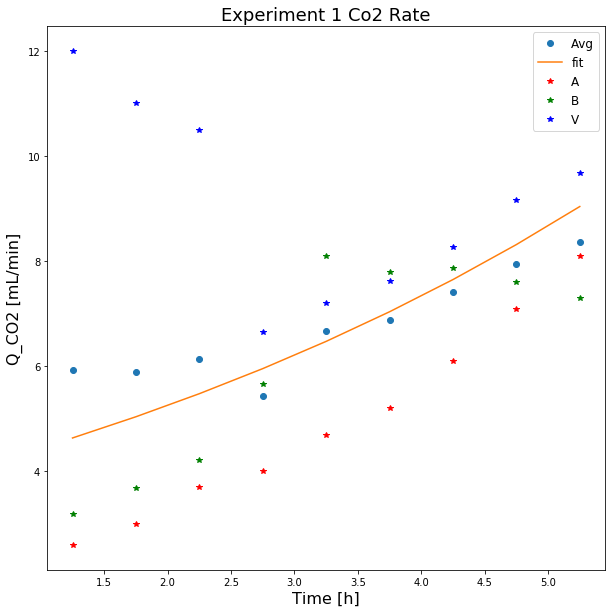

In [24]:
plt.figure(figsize=(10,10))

plt.title('Experiment 1 Co2 Rate', fontsize = 18)

plt.xlabel('Time [h]', fontsize = 16)
plt.ylabel('Q_CO2 [mL/min]', fontsize = 16)

plt.plot(t2,rco2_4_avg,"o", label='Avg')

plt.plot(t3_array,rco2_fit, label='fit')

plt.plot(t2,rco2_4_A,"*r", label='A')
plt.plot(t2,rco2_4_B,"*g", label='B')
plt.plot(t2,rco2_4_C,"*b", label='V')

plt.legend(loc='best', fontsize = 12)

plt.savefig('Rco2_E1.jpeg',dpi=1000)

# Plot Theory To Data

In [25]:
gamma = gamma_acc
# gamma = 1.45
mu, gamma

(0.1668644279014969, 1.381)

In [26]:
#Initial Concentrations at T=1.5

Cx0 = Cx_fit[0]/24.6  #Initial Biomass Concentration g/L
print (Cx0, "g/L")

Ce0=0.1 #Non zero but low Ethanol Concentration

Cg0=(25*2)/30 #Glucose as initially added

Co=[Cx0, Ce0, Cg0]

0.03804076168320378 g/L


In [27]:
t_0 = 1.5
t_add1 = 3.0
t_add2 = 4.0
tmax=6

t_important = [0,t_0,t_add1, t_add2, tmax]
t_important

[0, 1.5, 3.0, 4.0, 6]

In [28]:
C_sol=numpy.array([[],[],[]])
t_sol=numpy.array([])

for index,time in enumerate(t_important):
#     print (index,time)    
    
    if index==0:
        pass
    
    else:
        t_span=[t_important[index-1],time]
#         print (t_span)
        teval=numpy.arange(t_important[index-1],time+0.5,0.5)
        print (teval)
        C = scipy.integrate.solve_ivp(ferm_eq, t_span, Co, t_eval=teval)
#         print (C_sol,C.y)
        print (C.y)
        C_sol=numpy.concatenate((C_sol,C.y),axis=1)
        
#         print (Co, "Co pre")
        Cx0 = C.y[0,-1]
        Ce0 = C.y[1,-1]
        Cg0 = C.y[2,-1]+((5*2)/30)
        Co=[Cx0, Ce0, Cg0]
        t_sol=numpy.concatenate((t_sol,teval))
#         print (Co, "Co post")
    
print(C_sol, t_sol)

#There is a duplication of times, which is intentional to allow for plotting of the discontinous glucose concentrations

[0.  0.5 1.  1.5]
[[0.03804076 0.04135075 0.04494874 0.0488598 ]
 [0.1        0.11178777 0.12460119 0.13852953]
 [1.66666667 1.68898228 1.71323956 1.73960752]]
[1.5 2.  2.5 3. ]
[[0.0488598  0.05311117 0.05773245 0.06275584]
 [0.13852953 0.15366983 0.17012748 0.18801714]
 [2.07294085 2.10160319 2.13275944 2.16662664]]
[3.  3.5 4. ]
[[0.06275584 0.06821632 0.07415192]
 [0.18801714 0.20746343 0.22860177]
 [2.49995997 2.53677405 2.57679137]]
[4.  4.5 5.  5.5 6. ]
[[0.07415192 0.08060401 0.08761748 0.09524121 0.10352829]
 [0.22860177 0.25157944 0.27655638 0.30370659 0.33321921]
 [2.9101247  2.9536241  3.00090834 3.05230683 3.10817764]]
[[0.03804076 0.04135075 0.04494874 0.0488598  0.0488598  0.05311117
  0.05773245 0.06275584 0.06275584 0.06821632 0.07415192 0.07415192
  0.08060401 0.08761748 0.09524121 0.10352829]
 [0.1        0.11178777 0.12460119 0.13852953 0.13852953 0.15366983
  0.17012748 0.18801714 0.18801714 0.20746343 0.22860177 0.22860177
  0.25157944 0.27655638 0.30370659 0.3332

In [29]:
Cx=C_sol[0]*24.6             
print (Cx)
Ce=C_sol[1]*23

Cx_u = uniquify(numpy.array(Cx))
Cx_u

[0.93580274 1.01722847 1.10573902 1.20195103 1.20195103 1.30653476
 1.42021828 1.54379359 1.54379359 1.67812145 1.82413734 1.82413734
 1.98285861 2.15539009 2.3429337  2.54679596]


[0.935802737406813,
 1.0172284738701762,
 1.1057390249504104,
 1.201951025693059,
 1.3065347618804082,
 1.4202182809486206,
 1.5437935904982953,
 1.6781214544007068,
 1.8241373447266485,
 1.9828586119544584,
 2.1553900896742295,
 2.34293369968544,
 2.546795957075156]

In [30]:
# Cx_plot = numpy.concatenate((numpy.array([Cx_fit[0]]),Cx))
# t_sol_plot = numpy.concatenate((numpy.array([0]),t_sol))

In [31]:
Cx, t_sol

(array([0.93580274, 1.01722847, 1.10573902, 1.20195103, 1.20195103,
        1.30653476, 1.42021828, 1.54379359, 1.54379359, 1.67812145,
        1.82413734, 1.82413734, 1.98285861, 2.15539009, 2.3429337 ,
        2.54679596]),
 array([0. , 0.5, 1. , 1.5, 1.5, 2. , 2.5, 3. , 3. , 3.5, 4. , 4. , 4.5,
        5. , 5.5, 6. ]))

In [32]:
# Cx_plot, t_sol_plot

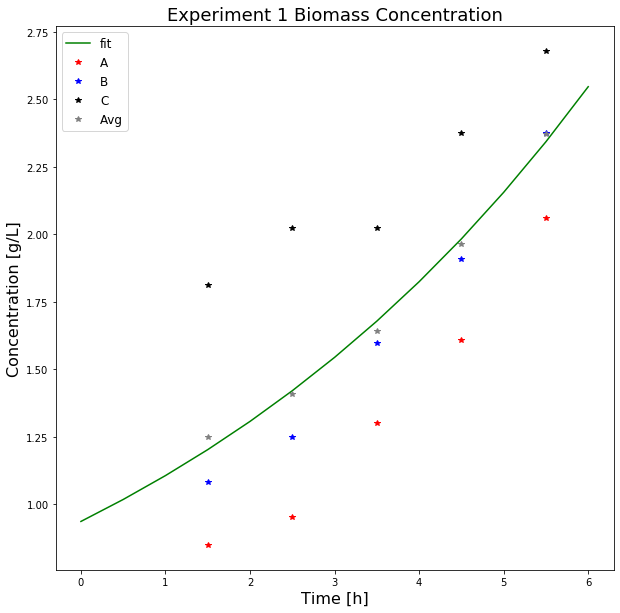

In [33]:
plt.figure(figsize=(10,10))

plt.title('Experiment 1 Biomass Concentration', fontsize = 18)

plt.xlabel('Time [h]', fontsize = 16)
plt.ylabel('Concentration [g/L]', fontsize = 16)

plt.plot(t_sol, Cx, "-",color='green',label='fit')
plt.plot(t1, Cx_4_A,'*', color='red', label='A')
plt.plot(t1, Cx_4_B,'*', color='blue', label='B')
plt.plot(t1, Cx_4_C, '*', color='black', label='C')
plt.plot(t1, Cx_4_avg, '*', color='grey', label='Avg')

plt.legend(loc='best', fontsize = 12)

plt.savefig('Cx_E1.jpeg',dpi=1000)

plt.show()



In [34]:
mu, gamma

(0.1668644279014969, 1.381)